In [7]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit - Fabio Palmisano -*-
# -*- date : 2024-01-20 -*-
# -*- Last revision: 2024-01-20 (Vincent Roduit)-*-
# -*- python version : 3.11.6 -*-
# -*- Description: Notebook that summarizes results-*-

# <center> EE - 411: Fundamentals of Inference and Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Deep Double Descent: When Bigger Models and More Data Hurt </center>
---

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Import librairies
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Import files
import constants

# 1. Data preprocessing

## 1.1 Load data

In [19]:
transform = transforms.Compose([
    transforms.ToTensor()
])

#Train Dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)
#Test Dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

Files already downloaded and verified
Files already downloaded and verified


## 1.2 Create Dataloader

In [21]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=constants.BATCH_SIZE,
    shuffle=True,
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=constants.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

## 1.3 Vizualize the Dataset

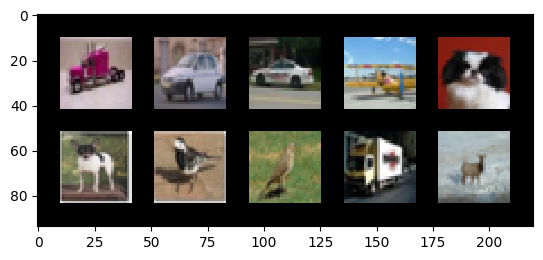

In [24]:
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)